# Introduction

For my semestral work, I have chosen to analyze the textual data from “PricewaterhouseCoopers Česká republika, s.r.o.” (PwC) and Price f(x) s.r.o. PwC, as one of the "Big Four" accounting firms, offers a diverse range of services, while Price f(x) specializes in pricing software solutions. This dual-company analysis aims to provide a comprehensive view of how professional services and software firms articulate their needs and values in their job opportunities and offerings. By examining these two companies, I aim to uncover the differences and similarities in their approaches to talent acquisition, role specifications, and thematic content.  

Let's start with importing all the necessary libraries and loading our scraped data. 

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import MDS
import plotly.express as px
import os
import tensorflow as tf
import warnings

# Set TensorFlow logging level to suppress warnings and info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0': all messages are logged, '1': filter out INFO messages, '2': filter out WARNING messages, '3': filter out INFO & WARNING messages

# Verify TensorFlow logging level
tf.get_logger().setLevel('ERROR')

/home/jupyter-trap09@vse.cz/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-09 13:22:43.607152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 13:22:43.689377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 13:22:44.833716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pricefx= pd.read_excel("pricefx.xlsx")
pwc= pd.read_excel("pwc.xlsx")

# Scraping
Firstly, I would like to show the code I used in Apify to scrape the data. Let's start with PwC's

This JavaScript function is designed for web scraping job postings using Apify. It leverages jQuery to extract key job details such as the job title, location, field, type, and ID from the page. Additionally, it retrieves the job description by first attempting to find a heading labeled "Job description" and collecting its subsequent content. If this fails, it looks for other indicative phrases within the text. The function logs the page URL and title for tracking purposes and returns the structured data in a consistent format for further processing and storage in a dataset.

Now the code for scraping PriceFX's job postings.

This function initializes an array to store job details and iterates through each job container to gather information such as department, job header, and location. It defines helper functions to extract text content under specific headers or strong tags, ensuring it captures sections like "Your mission," "You will be in charge of," and "What should you have to succeed?" If a header is not found, it attempts to find the information under strong tags. The extracted details are then compiled into an array of job objects, each containing the URL, page title, department, job header, job location, and the specific sections' content. Finally, the function logs the page URL and title for tracking purposes and returns the array of job objects for further processing.

# Preprocessing

I have imported all the necessary libraries and loaded the scraped data into our environment. For web scraping, I used Apify's 'Web Scraper' actor. To ensure a balanced comparison, I scraped 12 english job postings from each company. PwC has hundreds of job postings, while PriceFX had only 12 available, so I selected the most recent 12 from PwC's careers website.

To preprocess the data, I removed HTML tags, links, and images, converted the text to lowercase, and condensed multiple spaces into a single space. Additionally, some text elements became concatenated during the scraping process, so I implemented a method to separate these stuck-together words.

Finally, I removed common english stopwords.

In [3]:
# Download NLTK stop words
# nltk.download('stopwords')

english_stopwords = set(stopwords.words('english'))


def preprocess_text(text):
    if isinstance(text, str):
        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()
        # Remove links
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        # Remove images (assuming images are in the form of <img> tags)
        text = re.sub(r'<img[^>]*>', '', text)
        # Exclude "pwc" from being split
        text = re.sub(r'([a-z])([A-Z])(?!wc)', r'\1 \2', text)
        text = re.sub(r'([A-Z]+)([A-Z][a-z])(?!wc)', r'\1 \2', text)  # Handle cases like 'HTMLText'
        text = re.sub(r'([a-z])([0-9])', r'\1 \2', text)  # Handle cases like 'item1'
        text = re.sub(r'([0-9])([a-z])', r'\1 \2', text)  # Handle cases like '2020data'
        # Remove special characters
        text = re.sub(r'[/&-]', ' ', text)
        # Convert to lowercase
        text = text.lower()
        # Remove stop words
        text = ' '.join([word for word in text.split() if word not in english_stopwords])
        # Reduce multiple spaces to single space
        text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the preprocessing function to all columns of each DataFrame
def preprocess_dataframe(df):
    for column in df.columns:
        df[column] = df[column].apply(preprocess_text)
    return df

# Preprocess the DataFrames
pwc_cleaned = preprocess_dataframe(pwc.copy())
pricefx_cleaned = preprocess_dataframe(pricefx.copy())

# Display the first few rows of each DataFrame to verify
print("PwC DataFrame:")
print(pwc_cleaned.head())

print("\nPricefx DataFrame:")
print(pricefx_cleaned.head())


PwC DataFrame:
                                      jobDescription    jobDescriptionHeading  \
0  key member bd implementation team, global busi...  job description summary   
1  senior associate, you’ll gain depth knowledge ...  job description summary   
2  look large databases specific data. lead young...                      NaN   
3  passionate data eager expand skills knowledge?...  job description summary   
4  ideal candidate self starter eager stay date l...  job description summary   

    jobField            jobId                      jobLocation  \
0  assurance  job id 519660wd                              NaN   
1  assurance  job id 393296wd  location praha, česká republika   
2   advisory  job id 412651wd  location praha, česká republika   
3   advisory  job id 418403wd  location praha, česká republika   
4   advisory  job id 448181wd  location praha, česká republika   

                                            jobTitle               jobType  \
0  global business proj

/tmp/ipykernel_512999/504163014.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/tmp/ipykernel_512999/504163014.py:10: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


# Simple Explatory Data Analysis
Before proceeding with visualizations and text analysis tasks, I'll conduct a simple Exploratory Data Analysis (EDA) focusing on categorical data. This will help us understand the distributions through bar charts.

# EDA for PwC

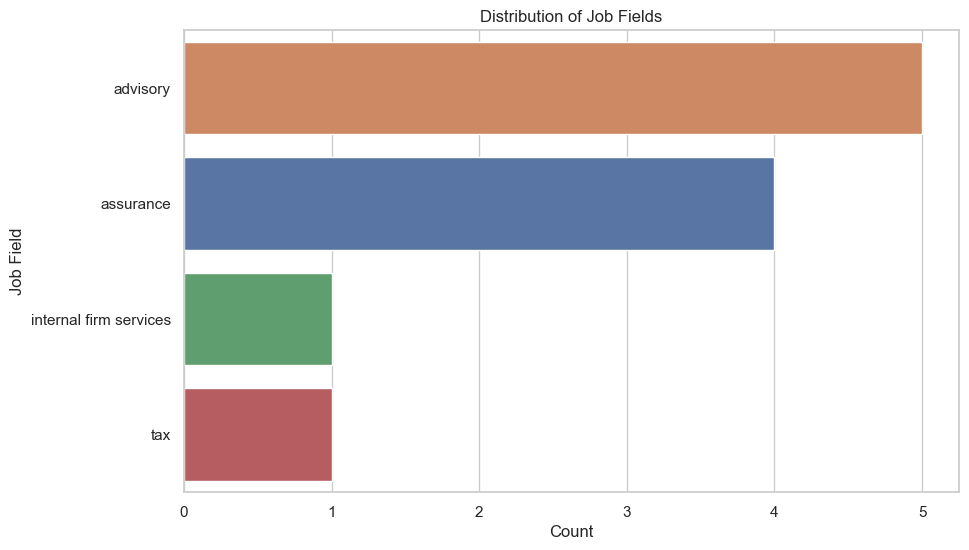

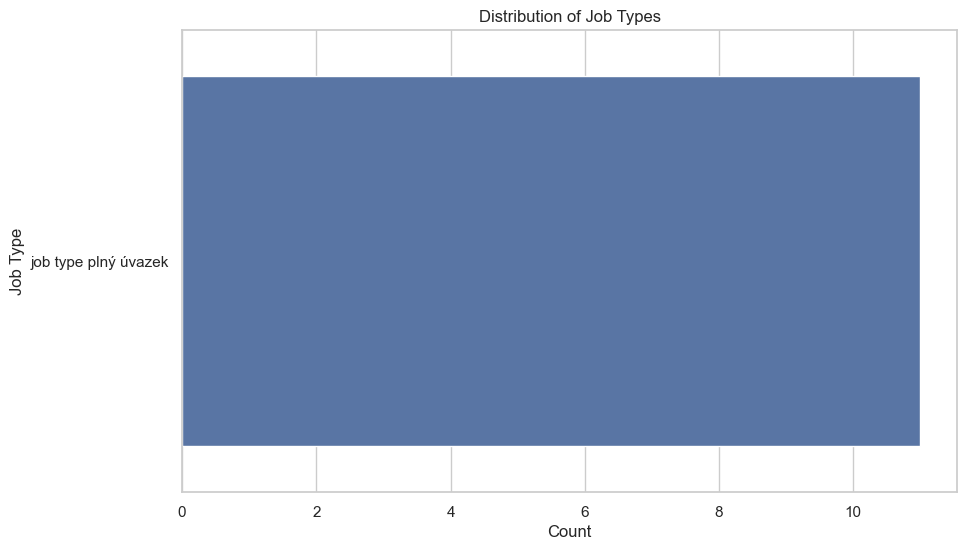

In [4]:
# Setting the style
sns.set(style="whitegrid")

# Plotting jobField distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='jobField', hue='jobField', data=pwc_cleaned, order=pwc_cleaned['jobField'].value_counts().index, palette="deep", dodge=False, legend=False)
plt.title('Distribution of Job Fields')
plt.xlabel('Count')
plt.ylabel('Job Field')
plt.show()

# Plotting jobType distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='jobType', hue='jobType', data=pwc_cleaned, order=pwc_cleaned['jobType'].value_counts().index, palette="deep", dodge=False, legend=False)
plt.title('Distribution of Job Types')
plt.xlabel('Count')
plt.ylabel('Job Type')
plt.show()

The bar chart for Job Fields illustrates the distribution within the PwC dataset, emphasizing four primary categories: "advisory," "assurance," "internal firm services," and "tax." Notably, the "advisory" and "assurance" fields are the most prominent, with five job postings in advisory and four in assurance, indicating that the majority of PwC's job postings fall within these two categories.

The Job Types chart reveals that all the job postings are for full-time positions, highlighting PwC's strong preference for hiring full-time employees.

Overall, the graphs suggest that PwC primarily focuses on advisory and assurance roles and exclusively offers full-time positions. However, it's important to note that this analysis is based on a small sample of 12 job postings, representing only the most recent English-language job listings and may not fully reflect PwC's entire range of job opportunities.

# EDA for PriceFX

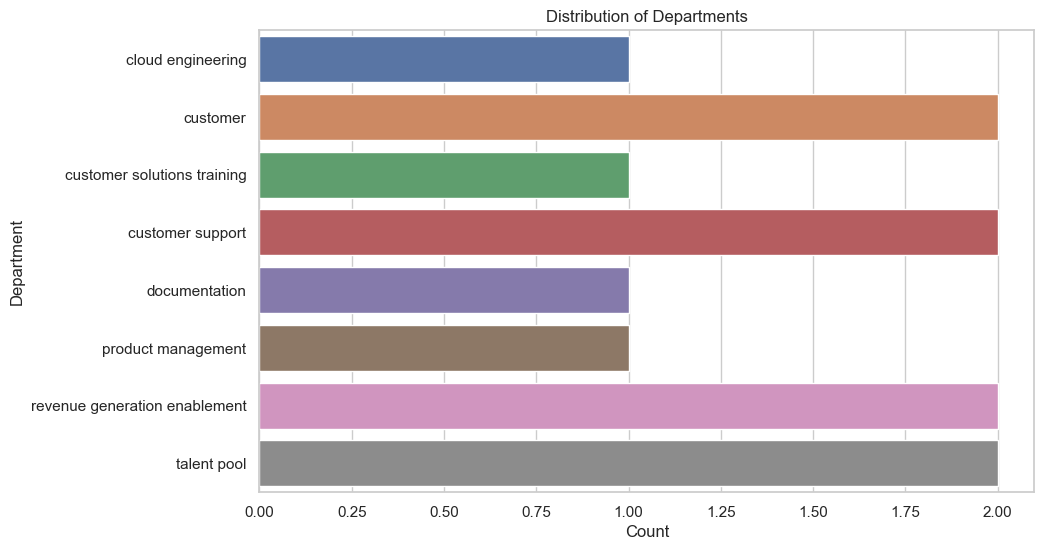

In [5]:
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Bar plot for Department distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=pricefx_cleaned, y='department', hue='department', palette='deep', dodge=False, legend=False)
plt.title('Distribution of Departments')
plt.xlabel('Count')
plt.ylabel('Department')
plt.show()


The first bar chart illustrates the distribution of job postings across various departments at PriceFX, highlighting Customer, Customer Support, Revenue Generation Enablement, and Talent Pool departments as having the highest number of postings. 

Overall, PriceFX's job postings appear to be more diverse compared to PwC's, although this observation might be influenced by the limited sample size from PwC's job listings.

# Word Cloud of PwC

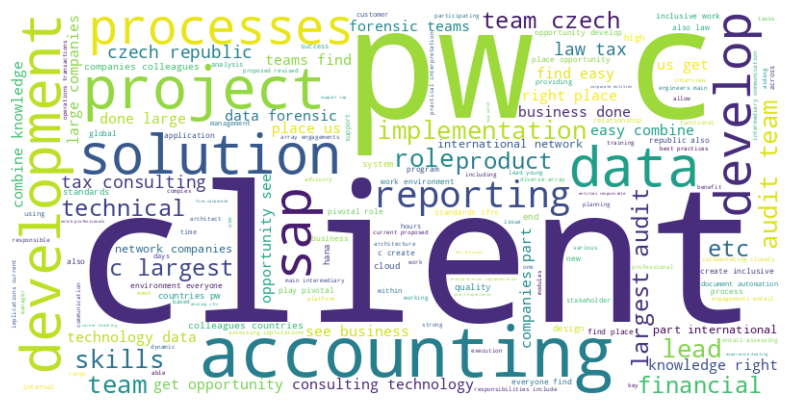

In [6]:
job_description_text = ' '.join(pwc_cleaned['jobDescription'].dropna().tolist())

# Preprocess the combined text
processed_text = preprocess_text(job_description_text)

# Generate the word cloud
wordcloud = WordCloud(stopwords=english_stopwords, width=800, height=400, background_color='white').generate(processed_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of PriceFX

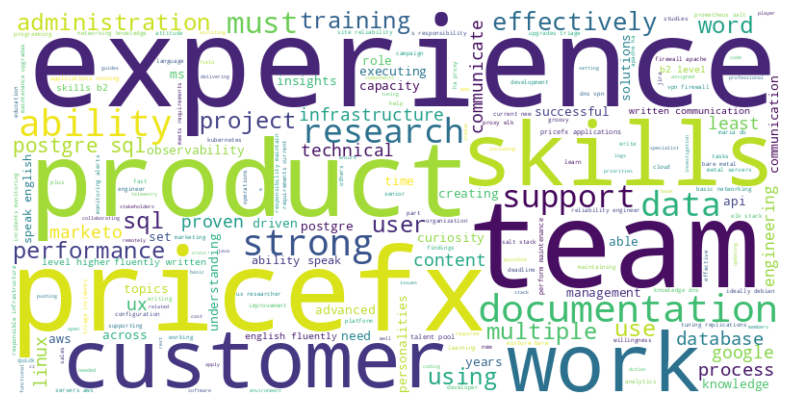

In [7]:
text_columns = ['department', 'jobHeader', 'whatYouShouldHaveToSucceed', 'youWillBeInChargeOf','yourMission']

# Combine the text from the relevant columns into a single text
combined_text = pricefx_cleaned[text_columns].fillna('').agg(' '.join, axis=1).str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Comparison of the word clouds of PwC and PriceFX

The word cloud for PwC's job requirements highlights a strong focus on client relationships, accounting, and project management. Prominent terms such as "client," "accounting," "project," "data," and "solution" indicate that PwC values expertise in client management, financial reporting, and data-driven project execution. The emphasis on terms like "client" and "accounting" suggests that PwC prioritizes roles involving direct client interaction and financial oversight. The presence of terms such as "development," "processes," and "implementation" underscores the importance of continuous improvement and operational efficiency within PwC. Overall, PwC's job requirements reflect a balanced emphasis on client-facing roles and operational management, combining business and technical aspects to foster comprehensive professional development.

In contrast, the word cloud for Pricefx's job requirements shows a heavy emphasis on technical skills, product management, and customer support. Key terms like "experience," "team," "product," "work," and "skills" suggest that Pricefx prioritizes technical proficiency and collaborative efforts within team environments. The focus on terms like "documentation" and "research" indicates a need for meticulous technical documentation and thorough research capabilities. Additionally, the emphasis on "customer" and "support" highlights the importance of ensuring customer satisfaction and delivering high-quality user experiences. Overall, Pricefx's job requirements are more technically oriented, with significant attention to specific technical skills such as "SQL," "Linux," and "infrastructure," reflecting a deep focus on product-specific knowledge and technical expertise.

By comparing these two word clouds, it is evident that PwC places a strong emphasis on client engagement and accounting roles, while Pricefx focuses more on technical proficiency and product management. Both companies prioritize team collaboration and effective communication, though their specific areas of focus and skill requirements differ significantly.

# Topic modelling

I will perform two types of topic modeling to analyze the job descriptions from PwC. First, I'll use the Latent Dirichlet Allocation (LDA) algorithm with Gensim. Then, I'll apply Non-negative Matrix Factorization (NMF) with TF-IDF vectorization.

By leveraging both methods, I aim to capitalize on their unique strengths: LDA with Gensim offers an interactive and detailed understanding of topics through visualization, making it particularly useful for intuitively exploring the relationships between topics. Conversely, NMF provides a simpler and more direct output by listing the top words for each topic, which is beneficial for quickly extracting and interpreting the main themes within the text data.

By utilizing both LDA and NMF, I aim to achieve a comprehensive understanding of the underlying topics in the job descriptions, balancing detailed exploration with quick interpretation.

# Topic modelling for PwC
Before I begin, I'll find the optimal number of topics.

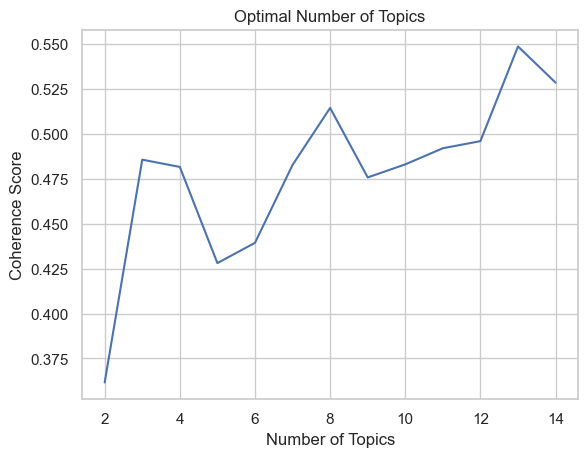

Num Topics = 2, Coherence Value = 0.3617
Num Topics = 3, Coherence Value = 0.4856
Num Topics = 4, Coherence Value = 0.4816
Num Topics = 5, Coherence Value = 0.4281
Num Topics = 6, Coherence Value = 0.4394
Num Topics = 7, Coherence Value = 0.4827
Num Topics = 8, Coherence Value = 0.5144
Num Topics = 9, Coherence Value = 0.4758
Num Topics = 10, Coherence Value = 0.4830
Num Topics = 11, Coherence Value = 0.4920
Num Topics = 12, Coherence Value = 0.4959
Num Topics = 13, Coherence Value = 0.5486
Num Topics = 14, Coherence Value = 0.5285


In [8]:
# Tokenize text
tokenized_text = [text.split() for text in pwc_cleaned['jobDescription'].dropna()]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Function to compute coherence score for a given number of topics
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
start, limit, step = 2, 15, 1
model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokenized_text, start, limit, step)

# Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()

# Print the coherence values for inspection
for m, cv in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics = {m}, Coherence Value = {cv:.4f}")


From the visualization and based on the coherence scores, the optimal number of topics is 13. So I'll continue with using 13 topics for my topic modelling for PwC

In [9]:
# Fit the LDA model using gensim
lda_model = gensim.models.LdaModel(corpus, num_topics=13, id2word=dictionary, random_state=42)

# Display the top words in each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(panel)

Topic 1: 0.011*"pw" + 0.009*"accounting" + 0.009*"clients" + 0.008*"application" + 0.008*"c" + 0.008*"also" + 0.007*"business" + 0.007*"data" + 0.007*"team" + 0.007*"project"
Topic 2: 0.015*"stakeholders" + 0.015*"data" + 0.010*"processes" + 0.009*"information" + 0.009*"different" + 0.008*"technology" + 0.008*"projects" + 0.008*"support" + 0.008*"create" + 0.008*"leading"
Topic 3: 0.014*"sap" + 0.014*"4hana" + 0.009*"cloud" + 0.009*"business" + 0.008*"development" + 0.007*"system" + 0.006*"enhancements" + 0.006*"abap" + 0.006*"implementation" + 0.006*"based"
Topic 4: 0.012*"accounting" + 0.006*"also" + 0.006*"team" + 0.006*"implementation" + 0.006*"support" + 0.005*"pw" + 0.005*"standards" + 0.005*"clients" + 0.005*"c" + 0.005*"reporting."
Topic 5: 0.020*"accounting" + 0.014*"clients" + 0.012*"process" + 0.011*"sap" + 0.010*"also" + 0.010*"4hana" + 0.008*"new" + 0.007*"role" + 0.007*"system" + 0.007*"setting"
Topic 6: 0.012*"audit" + 0.011*"pw" + 0.009*"quality" + 0.009*"team" + 0.008*

In [10]:
# Assuming english_stopwords is a set of stop words
english_stopwords_list = list(english_stopwords)

# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=100, stop_words=english_stopwords_list)
tfidf = tfidf_vectorizer.fit_transform(pwc_cleaned['jobDescription'])

# Apply NMF
nmf_model = NMF(n_components=13, random_state=42)
W = nmf_model.fit_transform(tfidf)
H = nmf_model.components_

# Display topics as full sentences
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    topic_sentence = " ".join([feature_names[i] for i in topic.argsort()[:-11:-1]])
    print(f"Topic {topic_idx + 1}: {topic_sentence}")

Topic 1: audit team pw teams work knowledge data consulting develop companies
Topic 2: global automation client business clients internal management across implementation project
Topic 3: lead solution project client implementation technical main solutions team knowledge
Topic 4: quality coaching skills development high develop audit clients diverse responsibilities
Topic 5: support create projects processes technology data within audit easy current
Topic 6: accounting clients process also processes system financial may reporting responsible
Topic 7: development cloud design solutions develop system using new implementation role
Topic 8: application project hours clients teams transactions roles corporate data internal
Topic 9: lead data cloud design engineers end large processes skills responsible
Topic 10: opportunity find companies place pivotal play responsibilities pw success solution
Topic 11: find opportunity companies place done pw inclusive everyone environment easy
Topic 12: 

# Topic Modelling for PriceFX
Let's do the same for PriceFX

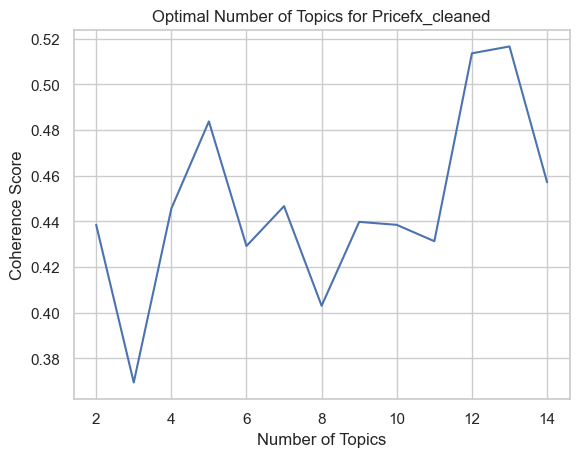

Num Topics = 2, Coherence Value = 0.4385
Num Topics = 3, Coherence Value = 0.3694
Num Topics = 4, Coherence Value = 0.4456
Num Topics = 5, Coherence Value = 0.4838
Num Topics = 6, Coherence Value = 0.4292
Num Topics = 7, Coherence Value = 0.4467
Num Topics = 8, Coherence Value = 0.4030
Num Topics = 9, Coherence Value = 0.4398
Num Topics = 10, Coherence Value = 0.4385
Num Topics = 11, Coherence Value = 0.4313
Num Topics = 12, Coherence Value = 0.5136
Num Topics = 13, Coherence Value = 0.5166
Num Topics = 14, Coherence Value = 0.4571


In [11]:
text_columns = ['whatYouShouldHaveToSucceed', 'youWillBeInChargeOf', 'yourMission']
combined_text_series = pricefx_cleaned[text_columns].fillna('').agg(' '.join, axis=1)

# Tokenize text
tokenized_text = [text.split() for text in combined_text_series]

# Create a dictionary and corpus
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Function to compute coherence score for a given number of topics
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
start, limit, step = 2, 15, 1
model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokenized_text, start, limit, step)

# Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics for Pricefx_cleaned")
plt.show()

# Print the coherence values for inspection
for m, cv in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics = {m}, Coherence Value = {cv:.4f}")

Here, we see that the optimal number of topics in case of PriceFX is also 13, so I'll continue with using 13 topics.

In [12]:
# Fit the LDA model using gensim
lda_model = gensim.models.LdaModel(corpus, num_topics=13, id2word=dictionary, random_state=42)

# Display the top words in each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

# Visualize the topics using pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(panel)


Topic 1: 0.017*"ability" + 0.012*"pricefx" + 0.012*"experience" + 0.009*"work" + 0.009*"product" + 0.007*"effectively" + 0.007*"skills" + 0.006*"english" + 0.006*"content" + 0.006*"multiple"
Topic 2: 0.011*"skills" + 0.010*"experience" + 0.010*"knowledge" + 0.010*"jira" + 0.009*"product" + 0.009*"–" + 0.009*"basic" + 0.009*"communication" + 0.007*"development" + 0.007*"programming"
Topic 3: 0.014*"ability" + 0.014*"pricefx" + 0.013*"skills" + 0.012*"stack" + 0.011*"experience" + 0.008*"english" + 0.008*"infrastructure" + 0.008*"level" + 0.008*"customers" + 0.008*"perform"
Topic 4: 0.012*"experience" + 0.012*"pricefx" + 0.008*"training" + 0.008*"open" + 0.008*"..." + 0.008*"attitude," + 0.008*"mind" + 0.008*"proactive" + 0.008*"work" + 0.007*"ability"
Topic 5: 0.009*"observability" + 0.007*"strong" + 0.006*"postgre" + 0.006*"postgres" + 0.005*"learn" + 0.005*"setting" + 0.005*"tuning" + 0.005*"stack" + 0.005*"research" + 0.005*"ability"
Topic 6: 0.040*"pricefx" + 0.024*"documentation" +

In [13]:
text_columns = ['whatYouShouldHaveToSucceed', 'youWillBeInChargeOf', 'yourMission']
pricefx_cleaned['combined_text'] = pricefx_cleaned[text_columns].fillna('').agg(' '.join, axis=1)

# Dynamically set max_df and min_df based on the number of documents
num_documents = len(pricefx_cleaned)
max_df_val = 1.0  # Allow terms that appear in 100% of the documents
min_df_val = 1  # Allow terms that appear in at least one document

# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=max_df_val, min_df=min_df_val, max_features=100, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(pricefx_cleaned['combined_text'])

# Apply NMF
nmf_model = NMF(n_components=13, random_state=42)
W = nmf_model.fit_transform(tfidf)
H = nmf_model.components_

# Display topics as full sentences
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    topic_sentence = " ".join([feature_names[i] for i in topic.argsort()[:-11:-1]])
    print(f"Topic {topic_idx + 1}: {topic_sentence}")

Topic 1: pricefx sql infrastructure aws stack team administration perform customers maintenance
Topic 2: multiple effectively ability skills able advanced driven ms personalities marketo
Topic 3: jira skills basic sql knowledge postgres api understanding development writing
Topic 4: postgres willingness understanding strong engineering team sql stack set use
Topic 5: documentation api jira engineering effective ux teams tasks communicate requirements
Topic 6: research ux product strong data user effective communication executing successful
Topic 7: maintenance perform aws upgrades applications infrastructure capacity performance kubernetes new
Topic 8: administration aws using incidents prometheus dns servers salt stack ha
Topic 9: pricefx product use documentation user team technical set solutions fast
Topic 10: attitude performance level written ability english skills communicate multiple effectively
Topic 11: training education creating content product experience pricefx ability top

# Comparison of the topic modelling of the two companies
In the LDA topic modelling analysis for PwC's job requirements, the model underscores a significant emphasis on accounting, business operations, client relationships, and project management. Key terms such as "accounting," "business," "team," "clients," and "data" highlight PwC's demand for expertise in financial analysis, project management, and data handling. The prominence of terms like "team" and "clients" indicates that PwC values collaborative efforts and client-facing roles, striving to nurture strong client relationships and effective teamwork. Overall, PwC's job requirements achieve a balance between technical and business competencies, emphasizing the importance of experience and professional growth in various positions.

Conversely, the topic model for Pricefx's job requirements reveals a strong emphasis on technical skills, product management, and customer support. Notable terms like "experience," "team," "skills," "product," and "documentation" suggest that Pricefx prioritizes technical proficiency, particularly in areas such as infrastructure, UX, and engineering. The focus on "documentation" and "research" underscores the need for meticulousness and technical writing capabilities. Additionally, the emphasis on "customer" and "support" highlights the significance of customer satisfaction and user experience in their product-centric roles. Overall, Pricefx's job requirements are more technically oriented, with a substantial focus on product-specific knowledge, technical expertise, and comprehensive documentation.

By comparing these two models, it is evident that PwC places a strong emphasis on business operations and client relations, while Pricefx focuses more on technical skills and product management. Both companies prioritize teamwork and effective communication, although their specific areas of focus and skill requirements differ significantly.   





With NMF modeling, the topic model for PwC's job requirements reveals a comprehensive focus on business operations, project management, and client relationships. The topics emphasize data and cloud technologies, suggesting that candidates need robust technical skills coupled with strong business acumen. Terms such as "audit," "team," "clients," "data," "consulting," and "develop" highlight the importance of expertise in these areas. Additionally, the inclusion of terms related to learning, career growth, and consultancy indicates that PwC values continuous professional development and the ability to work independently while effectively collaborating with teams. The emphasis on technical systems and specific solutions underscores the need for specialized knowledge to support business automation and client projects.

In contrast, the NMF topic model for Pricefx's job requirements highlights a strong emphasis on technical skills and product-specific knowledge. Key topics include the maintenance of AWS infrastructure, proficiency with Linux, and deep expertise in PostgreSQL and SQL. Terms such as "pricefx," "sql," "infrastructure," "aws," "stack," and "team" suggest a focus on technical proficiency and infrastructure management. The model also underscores the importance of technical programming, research, and effective communication. There is a notable focus on documentation and the ability to manage APIs, reflecting the necessity for thorough technical documentation skills. Additionally, topics related to customer support, stakeholder engagement, and language skills, particularly in English and SQL, indicate that Pricefx prioritizes comprehensive technical capabilities and effective communication in their roles.

# Text clustering for PwC

In [14]:
# Assuming pwc_cleaned is your DataFrame
# Concatenate the relevant columns into a single text column
pwc_cleaned['combined_text'] = pwc_cleaned[['jobDescription', 'jobField', 'jobTitle']].apply(lambda x: ' '.join(x), axis=1)

# Ensure no column is empty
pwc_cleaned['combined_text'].replace('', np.nan, inplace=True)
pwc_cleaned.dropna(subset=['combined_text'], inplace=True)


# Load the pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the combined text columns to get embeddings
sentences = pwc_cleaned['combined_text'].tolist()
embeddings = model.encode(sentences)

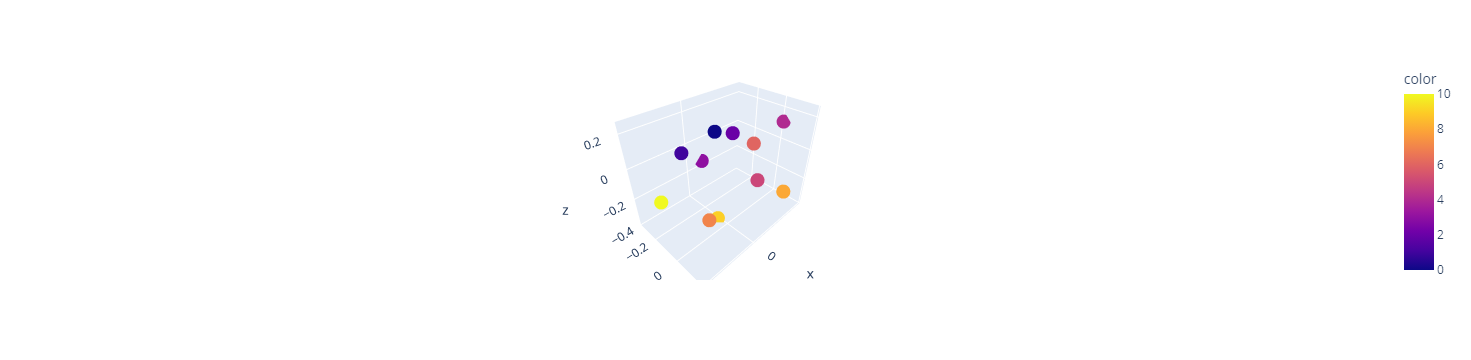

In [15]:
#### Calculate pairwise cosine distances between embeddings
distances = cosine_distances(embeddings)

# Apply MDS for dimensionality reduction to 3D
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
embeddings_mds = mds.fit_transform(distances)

# Create a DataFrame for the MDS embeddings
df = pd.DataFrame(
    embeddings_mds,
    columns=['x', 'y', 'z']
)

# Add the original sentences for hover information
df['text'] = ['<br>'.join(s[i:i+30] for i in range(0, min(300, len(s)), 30)) + '...' for s in sentences]

# Add a color column for visualization
df['color'] = np.arange(len(sentences))

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='color', hover_name='text')

# Show the plot
fig.show()


# Text clustering for PriceFX

In [16]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the combined text columns to get embeddings
sentences = pricefx_cleaned['combined_text'].tolist()
embeddings = model.encode(sentences)

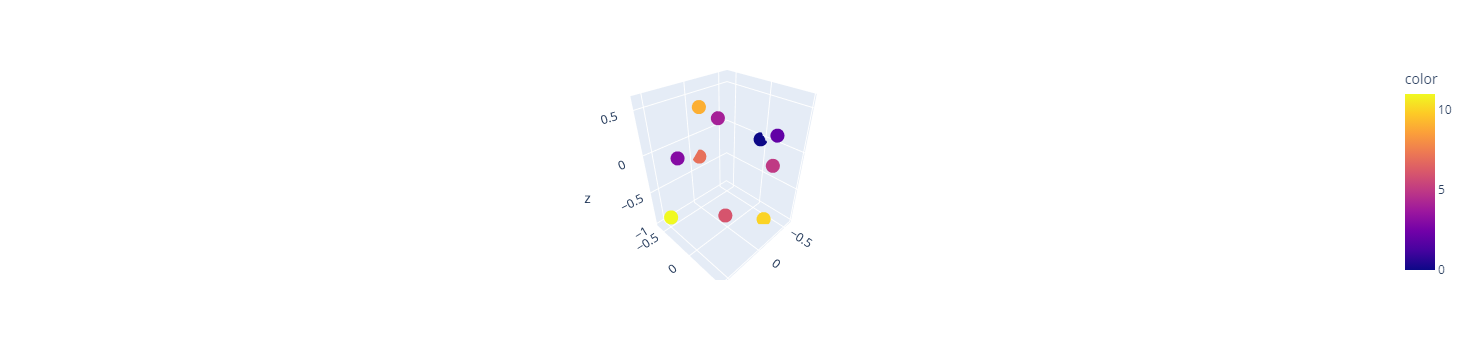

In [17]:
# Determine the appropriate number of components for MDS
n_samples, n_features = embeddings.shape
n_components = min(3, n_samples, n_features)

# Apply MDS for dimensionality reduction to n_components
mds = MDS(n_components=n_components, random_state=42)
embeddings_mds = mds.fit_transform(embeddings)

# Create a DataFrame for the MDS embeddings
columns = ['x', 'y', 'z'][:n_components]
df = pd.DataFrame(
    embeddings_mds,
    columns=columns
)

# Add the original sentences for hover information
df['text'] = ['<br>'.join(s[i:i+30] for i in range(0, min(300, len(s)), 30)) + '...' for s in sentences]

# Add a color column for visualization
df['color'] = np.arange(len(sentences))

# Create a 3D scatter plot if n_components is 3, otherwise create a 2D scatter plot
if n_components == 3:
    fig = px.scatter_3d(df, x='x', y='y', z='z', color='color', hover_name='text')
elif n_components == 2:
    fig = px.scatter(df, x='x', y='y', color='color', hover_name='text')
else:
    print("Not enough components for a meaningful scatter plot")

# Show the plot if it was created
if 'fig' in locals():
    fig.show()

# Comparison of text clustering of the two companies
The first cluster plot, representing PwC's text clustering, exhibits a more dispersed arrangement of points with numerous smaller sub-clusters within the main groups. The data points are more widely distributed, indicating a greater range of variation within the clusters. The color representation reveals a mix of clusters, suggesting a diversity of topics or roles within PwC's job descriptions. This diversity underscores PwC's extensive focus on various business operations, client relationships, and technical skills. The scattered distribution of points highlights PwC's broad and varied approach to job roles, covering a wide array of functions and responsibilities.

On the other hand, the second cluster plot, which represents Pricefx's text clustering, features tighter groupings of points, indicating clearer separation and more compact clusters. The clusters are more distinctly formed, with less spread among the points. The color representation in this plot suggests a more defined categorization with less variation within each cluster. This indicates that Pricefx's job descriptions emphasize specific technical skills, product management, and customer support, with clear distinctions between different technical roles and expertise. The compact clustering reflects Pricefx's focused and specialized approach to job roles, emphasizing precise technical competencies and structured job functions.

When examining the cluster points manually, we observe that points closest to each other are indeed very similar in content. This further validates the clustering approach and highlights the differences in how PwC and Pricefx define and categorize their job roles. PwC shows a broader, more diverse range of job descriptions, while Pricefx demonstrates a more concentrated, specialized focus in its job roles.

# Conclusion

The analysis of job postings from PwC and Pricefx highlights distinct hiring priorities and approaches. PwC's job postings predominantly focus on the "advisory" and "assurance" fields, with a strong preference for full-time positions. The word cloud analysis reveals an emphasis on client relationships, accounting, project management, and data handling, indicating a balanced focus on business operations and technical skills. Both LDA and NMF topic modeling underscore PwC's demand for expertise in financial analysis, project management, and continuous professional development. The dispersed clustering pattern further reflects a diverse range of job roles and responsibilities within PwC, showcasing their broad approach to business and client operations.

Conversely, Pricefx's job postings demonstrate a significant concentration in technical skills, product management, and customer support. The word cloud analysis points to a strong emphasis on technical proficiency, particularly in areas like SQL, Linux, and infrastructure, with a notable focus on documentation and customer satisfaction. Topic modeling using both LDA and NMF confirms Pricefx's specialized focus on technical expertise and infrastructure management. The tighter clustering pattern indicates more defined job roles, emphasizing precise technical competencies and structured functions. Overall, PwC exhibits a broader and more varied approach to job roles, while Pricefx focuses on specialized technical skills and product-specific knowledge.

However, it is important to keep in mind that the sample size taken from PwC job postings was relatively small compared to their entire pool of job listings. I chose to analyze the most recent 12 postings to maintain a fair comparison, as Pricefx, being a smaller company, naturally has fewer open positions. Consequently, the findings for PwC may be skewed due to this limited sample size and should be interpreted with caution.s.